<a href="https://colab.research.google.com/github/Thomasvidalenc/DMML2022_IWC/blob/main/ThirdPart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Welcome to our third part where we will use a camembert model.
#A Tasty French Language Model :)



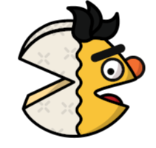

First of all we want to apologize. We did not achieve to separate the functions and class in an other file due to a lack of time. However, we hop that you will enjoy the reading.

As always, we have to install and prepare the environment of work

In [94]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [95]:
%%capture
! pip install kaggle

In [96]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [97]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [98]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [99]:
%%capture
! kaggle competitions download -c detecting-french-texts-difficulty-level-2022

In [100]:
%%capture
!unzip "detecting-french-texts-difficulty-level-2022.zip" -d data

In [101]:
%%capture
! pip install datasets

In [102]:
%%capture
! pip install pytorch_lightning

In [103]:
!pip install transformers plotly==5.8.0 pyyaml==5.4.1 datasets pytorch-lightning > /dev/null 2>&1

In [104]:
import functools
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm
import pandas as pd

In [105]:
def submission(id, prediction):
  d = {'id': id, 'difficulty': prediction}
  df = pd.DataFrame(data=d)
  return df

Let's download the camembert model thanks to the free open library Hugging Face.

In [106]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base')
camembert = CamembertForMaskedLM.from_pretrained('camembert-base')

We download also our data from Hugging face

In [107]:
data = load_dataset("Vidalloka/train_dmml")

  0%|          | 0/3 [00:00<?, ?it/s]

We take a look to our data

In [108]:
data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'difficulty', 'label'],
        num_rows: 3840
    })
    test: Dataset({
        features: ['sentence', 'difficulty', 'label'],
        num_rows: 1200
    })
    validation: Dataset({
        features: ['sentence', 'difficulty', 'label'],
        num_rows: 960
    })
})

We can see that above that we have 3 features. That's the case because the model need it to work. 

Let's get the 3 split that we will need later

In [109]:
train_data, test_data,val_data = data.values()

We define our tokenizer

In [110]:
def tokenize_batch(samples, tokenizer):
    text = [sample["sentence"] for sample in samples]
    labels = torch.tensor([sample["label"] for sample in samples])
    str_labels = [sample["difficulty"] for sample in samples]
    tokens = tokenizer(text, padding="longest", return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

We create the class LightningModel in relation to Pytorch. LightningModel is a PyTorch class that is designed to be used as a base class for building machine learning models.The LightningModel class provides a number of features that help the process of building and training machine learning models

In [111]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [112]:
lightning_model = LightningModel("camembert-base", 6, lr=3e-5, weight_decay=2.) 
#lr is the learning rate, it means how quickly the model's parameters should be updated during training
#weight_decay permits to control the risk of overfitting

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

Here we ask the model to save the best one across the epochs. The epochs describes the number of time that the model will see the data. Here the model can possibly see our data 20 times but it will stop before thanks to the earlystopping that permits also to avoid overfitting. 

In [113]:
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=20,
    gpus=1,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


DataLoader will provide data to the model in batch. Batch are examples that are given to the models on the training stage. Also, We set shuffle=True because we don't want that the model see the data on the same order across the epochs.

In [114]:
train_dataloader = DataLoader(
    data["train"], 
    batch_size=16, 
    shuffle=True,
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)
val_dataloader = DataLoader(
    data["validation"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)
test_dataloader = DataLoader(
    data["test"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)


We can launch our first fit.

In [115]:
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M 
-------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.506   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

We get here the best model across the epochs thanks to the checkpoint.

In [116]:
lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=model_checkpoint.best_model_path)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

Then, we can make a prediction. Let's see what will happen!

In [117]:
camembert_predict = camembert_trainer.predict(lightning_model, dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 240it [00:00, ?it/s]

 We concatenate tensors along the right dimension.

In [118]:
camembert_preds = torch.cat(camembert_predict, -1)

Suspense...

In [119]:
values = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
print("Evaluation of Camembert model:")
report = classification_report(data['validation']['label'], camembert_preds, target_names= values)
print(report)

Evaluation of Camembert model:
              precision    recall  f1-score   support

          A1       0.78      0.67      0.72       166
          A2       0.50      0.55      0.52       158
          B1       0.56      0.57      0.57       166
          B2       0.54      0.60      0.57       153
          C1       0.51      0.54      0.52       152
          C2       0.68      0.58      0.63       165

    accuracy                           0.59       960
   macro avg       0.59      0.59      0.59       960
weighted avg       0.60      0.59      0.59       960



We can see above that we have good results. So, We will make a prediction on the unlabelled set. 

In [120]:
camembert_predict = camembert_trainer.predict(lightning_model, dataloaders=test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 240it [00:00, ?it/s]

In [121]:
camembert_predict = torch.cat(camembert_predict, -1)

In [122]:
df_final_test = submission(df_test['id'], camembert_predict)

In [123]:
df_final_test['difficulty'] = ['A1' if x == 0
                   else 'A2' if x == 1
                   else 'B1' if x == 2
                   else 'B2' if x == 3
                   else 'C1' if x == 4
                   else 'C2'
                   for x in df_final_test['difficulty']]
df_final_test

,id,difficulty
0,0,C2
1,1,B1
2,2,B2
3,3,A2
4,4,C2
...,...,...
1195,1195,B1
1196,1196,A2
1197,1197,C2
1198,1198,B2


We upload it on Kaggle to see the result.

In [124]:
df_final_test.to_csv('test_cnn2.csv', header=True, index=False)

We upload it on Kaggle and reached a score of 0.57833